# Shooting Methods

Key concept: given a set of inputs, integrate the motion forwards and determine a cost.  Use that cost, as a function of the inputs, in a numerical optimizer: find the control inputs that minimize the cost.

## Single Shooting

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from math import cos,sin
x0 = np.array([0,0,-np.pi/4.])
d = np.array([0,0.1])

plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.show()

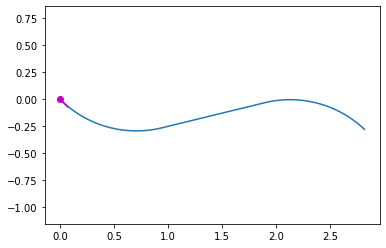

In [2]:
def f(x,u):
    return(np.array([u[0]*cos(x[2]),u[0]*sin(x[2]),u[0]*u[1]]))

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

uv = np.array([[1.,1.],[1.,0.],[1.,-1.],[1.,0.]])
tv = np.array([0.,1.,2.,3.])
ut = interp1d(tv,uv,axis=0,kind='previous')

def fc(t,x):
    u = ut(t)
    return(f(x,u))

te=np.linspace(0.,max(tv),100)
r = solve_ivp(fc,(min(te),max(te)),x0,t_eval=te)
plt.plot(r.y[0,:],r.y[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.axis('equal')
plt.show()

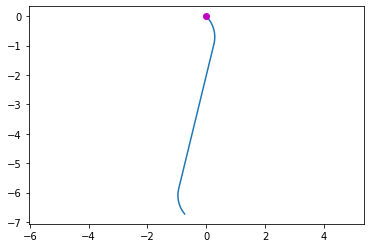

In [3]:
# define decision variable as vector of [time,curv,time,curv,time,curv]
z = np.array([1.,-1.,5.,0.,1.,1.])

def path(z):
    # make sure it has even number of elements
    nz = len(z)
    assert(nz%2==0)
    # curvature values
    kv = z[range(1,nz,2)]
    dv = z[range(0,nz,2)]
    #assert(all(dv>0))
    dv = [max(v,0) for v in dv]
    nv = len(kv)
    uv = np.vstack((np.ones((1,nv+1)),np.hstack((kv,0.))))
    tv = np.cumsum(np.append(0,dv))
    te=np.linspace(0.,max(tv),100)
    ut = interp1d(tv,uv,axis=1,kind='previous',bounds_error=False,fill_value='extrapolate')
    def fc(t,x):
        #print(dv,tv,t)
        u = ut(t)
        return(f(x,u))
    r = solve_ivp(fc,(min(te),max(te)),x0,t_eval=te)
    return(r.y)

p = path(z)

plt.plot(p[0,:],p[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.axis('equal')
plt.show()

In [4]:
from scipy.linalg import norm

p_goal = np.array([6.,4.,-np.pi/4])

def J(z):
    p = path(z)
    return(norm(p[0:3,-1]-p_goal))

print(J(z))

12.662599419995676


In [5]:
curv_lim = 1.1
bnds = [b for ii in range(len(z)//2) for b in [(0.1,10.0),(-curv_lim,curv_lim)]]
bnds

[(0.1, 10.0), (-1.1, 1.1), (0.1, 10.0), (-1.1, 1.1), (0.1, 10.0), (-1.1, 1.1)]

In [6]:
from scipy.optimize import minimize

r = minimize(J,z,method='SLSQP',bounds=bnds)
print(r)

     fun: 0.11546139377181554
     jac: array([-0.78084014,  4.21821276, -0.78084014,  9.41852396, -0.78084014,
        0.03803624])
 message: 'Optimization terminated successfully.'
    nfev: 234
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([ 1.82527279,  0.91008007,  4.61155874,  0.03984777,  1.82527279,
       -0.91357681])


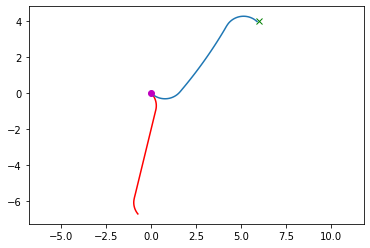

In [7]:
popt = path(r.x)
plt.plot(p[0,:],p[1,:],'r')
plt.plot(popt[0,:],popt[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

In [8]:
def Jsp(z):
    tf = sum(z[range(0,len(z),2)])
    ge = J(z)
    return(0.1*tf+100.*ge)

print(Jsp(z))

1266.9599419995677


In [9]:
r = minimize(Jsp,z,method='SLSQP',bounds=bnds)
print(r)

     fun: 400.3843645877866
     jac: array([-9.29893417e+01,  9.37134520e+07, -9.29893417e+01, -3.07600372e+02,
       -9.29893417e+01, -9.13446426e+00])
 message: 'Inequality constraints incompatible'
    nfev: 66
     nit: 7
    njev: 7
  status: 4
 success: False
       x: array([ 0.72173449,  1.09997919,  2.53478154,  0.28239041,  0.72173449,
       -1.1       ])


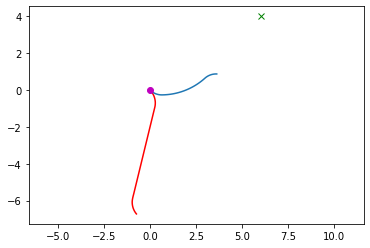

In [10]:
popt = path(r.x)
plt.plot(p[0,:],p[1,:],'r')
plt.plot(popt[0,:],popt[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

In [11]:
def Jspbdd(z):
    J = Jsp(z)
    for (ii,(lo,hi)) in enumerate(bnds):
        if z[ii]>hi:
            J = J + 1e2*(z[ii]-hi)
        elif z[ii]<lo:
            J = J + 1e2*(lo-z[ii])
    return(J)

print(Jspbdd(z))

1266.9599419995677


In [12]:
r = minimize(Jspbdd,z,method='Powell')
print(r)

   direc: array([[-1.73875204e-03,  1.21304533e-05,  1.63276654e-07,
         4.32427309e-09,  4.03721605e-03, -2.99892703e-12],
       [-1.03454788e-02,  1.22009701e-04, -5.00419454e-02,
         3.73031798e-03,  4.27392018e-02, -2.15645415e-03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-7.03659746e-03,  3.96221690e-02,  3.55508394e-03,
         3.93614142e-02,  1.19853234e-01, -1.05148972e-02]])
     fun: 11.79380255333451
 message: 'Optimization terminated successfully.'
    nfev: 2692
     nit: 23
  status: 0
 success: True
       x: array([ 1.35049472,  1.00141749,  1.296813  ,  1.07743261,  7.02541616,
       -0.36391805])


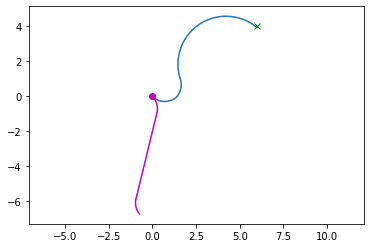

In [13]:
popt = path(r.x)
plt.plot(p[0,:],p[1,:],'m')
plt.plot(popt[0,:],popt[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

## Multiple Shooting

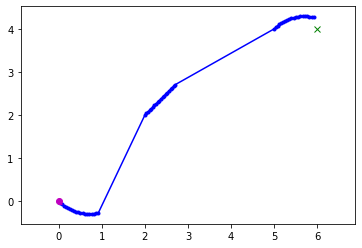

In [14]:
# define decision variable as vector of [time,curv,state,time,curv,state,time,curv]
zm = np.array([1.,1.,   2.,2.,np.pi/4,1.,0.,   5.,4.,np.pi/4,1.,-1.])

def pathm(z):
    # make sure it has N*5 + 2 elements
    nz = len(z)
    assert((nz-2)%5==0)
    # initial curvature values
    ix = 0
    xs = np.array([x0])
    xi = x0
    while ix<nz:
        def fm(t,x):
            u = np.array([1.,z[ix+1]])
            return(f(x,u))
        te=np.linspace(0.,z[ix],20)
        r = solve_ivp(fm,(0.,z[ix]),xi,t_eval=te)
        xs = np.append(xs,np.transpose(r.y),0)
        ix = ix+5
        xi = z[(ix-3):ix]
    return(xs)

p = pathm(zm)

plt.plot(p[:,0],p[:,1],'-b.')
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

In [15]:
def Jm(z):
    tf = sum(z[range(0,len(z),5)])
    p = pathm(z)
    ge = norm(p_goal-p[-1,:])
    for ii in range(20,len(p)-1,20):
        ge=ge+norm(p[ii,:]-p[ii+1,:])
    return(0.1*tf+100.*ge)

print(Jm(zm))

584.9484849926286


In [16]:
x_lim = 10
th_lim = np.pi
bndsm = [b for ii in range(len(z)//2) for b in [(0.1,10.0),(-curv_lim,curv_lim),(-x_lim,x_lim),(-x_lim,x_lim),(-th_lim,th_lim)]]
bndsm = bndsm[0:-3]
assert(len(bndsm)==len(zm))
bndsm

[(0.1, 10.0),
 (-1.1, 1.1),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (-1.1, 1.1),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (-1.1, 1.1)]

In [17]:
r = minimize(Jm,zm,method='SLSQP',bounds=bndsm)
print(r)

     fun: 0.936706065078733
     jac: array([-8.54094381e+01, -4.89150975e+02, -5.58404043e+01,  7.31036805e+01,
        3.15112480e+02, -3.05629201e-01,  5.03110750e+02, -7.10020831e+01,
       -5.67757088e+01, -7.71882386e+01, -7.06567715e+01, -7.70146191e+01])
 message: 'Optimization terminated successfully.'
    nfev: 875
     nit: 55
    njev: 55
  status: 0
 success: True
       x: array([ 3.442081  ,  0.69251184,  2.46455126,  1.06070985,  1.59828563,
        3.17566814, -0.24487795,  3.55915786,  3.95701102,  0.82061804,
        2.72475153, -0.58941744])


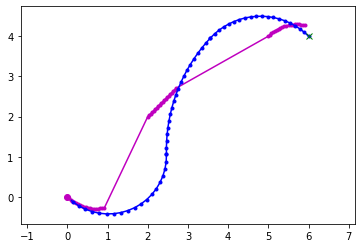

In [18]:
popt = pathm(r.x)

plt.plot(p[:,0],p[:,1],'-m.')
plt.plot(popt[:,0],popt[:,1],'-b.')
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

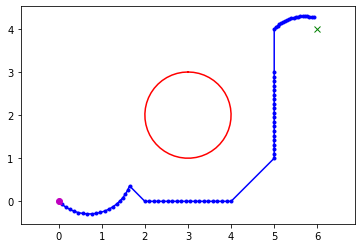

In [25]:
# define decision variable as vector of [time,curv,state,time,curv,state,time,curv]
zmo = np.array([1.,1.,   2.,2.,np.pi/4,1.,0.,   3.,4.,np.pi/4,1.,-0.,   5.,4.,np.pi/4,1.,-1.])
zmo = np.array([2.,1.,   2.,0.,0*np.pi/4,2.,0.,   5.,1.,2*np.pi/4,2.,0.,   5.,4.,np.pi/4,1.,-1.])

c_obs = np.array([3,2])
r_obs = 1.
ths = np.linspace(0.,2*np.pi,50)
plt.plot(c_obs[0]+r_obs*np.array([sin(th) for th in ths]),c_obs[1]+r_obs*np.array([cos(th) for th in ths]),'r-')

p = pathm(zmo)

plt.plot(p[:,0],p[:,1],'-b.')
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

In [26]:
def Jmo(z):
    tf = sum(z[range(0,len(z),5)])
    p = pathm(z)
    ge = norm(p_goal-p[-1,:])
    for ii in range(20,len(p)-1,20):
        ge=ge+norm(p[ii,:]-p[ii+1,:])
    op = 0.
    for pp in p:
        inc = r_obs - norm(pp[0:2]-c_obs)
        if inc>0:
            op = op + inc
    return(0.1*tf+100.*ge + 50.*op)

print(Jmo(zm))

793.1323021409326


In [27]:
bndsmo = [b for ii in range((7+len(zmo))//5) for b in [(0.1,10.0),(-curv_lim,curv_lim),(-x_lim,x_lim),(-x_lim,x_lim),(-th_lim,th_lim)]]
bndsmo = bndsmo[0:-3]
assert(len(bndsmo)==len(zmo))
bndsmo

[(0.1, 10.0),
 (-1.1, 1.1),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (-1.1, 1.1),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (-1.1, 1.1),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (-1.1, 1.1)]

In [28]:
r = minimize(Jmo,zmo,method='SLSQP',bounds=bndsmo)
print(r)

     fun: 0.9344955152512835
     jac: array([ -71.53482575,  -96.46252575,  -18.35108881,  -21.5111002 ,
         91.15797999,  -42.99088428,  -85.49214793,  136.4553502 ,
        -61.07242369, -172.10051999,  -52.30267439, -340.81457232,
       -141.36020167,  -20.77189245,  -10.91164282,  -42.84116824,
        -36.77680793])
 message: 'Optimization terminated successfully.'
    nfev: 1524
     nit: 71
    njev: 71
  status: 0
 success: True
       x: array([ 1.59163957,  0.54867237,  1.44874242, -0.52678901,  0.08789524,
        2.37486498,  0.36407135,  3.44586441,  0.61722923,  0.95251981,
        2.63960403,  0.26991881,  4.11526839,  3.11314992,  1.66499919,
        2.71241312, -0.90340032])


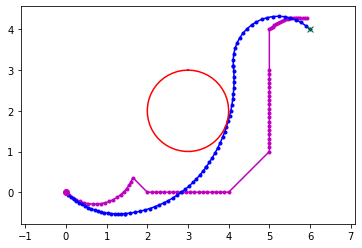

In [29]:
popt = pathm(r.x)

plt.plot(p[:,0],p[:,1],'-m.')
plt.plot(popt[:,0],popt[:,1],'-b.')
plt.plot(c_obs[0]+r_obs*np.array([sin(th) for th in ths]),c_obs[1]+r_obs*np.array([cos(th) for th in ths]),'r-')
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.plot()
plt.axis('equal')
plt.show()